# Data preprocessing

This notebook is intended to preprocess the scrapped data from Airbnb. This data has been provided by Pere Antoni Manresa and Jordi Vitrià.

We perform the following steps:
    - Visualize data in order to explore the nature of the columns
    - Simplify data in order to store non-relevant or redundant information
    - Identify missing values and apply criteria
    - Build new data resulting from previous actions
    
First, let's load the original data.

In [1]:
import json
import pandas
import tempfile
import os
import numpy as np

from widedeep.data.display import *
from widedeep.utils import *
from widedeep.data.data_ops import *

%matplotlib inline
pandas.set_option("display.max_columns", 50)

bcn_map = BARCELONA_NEIGH # Path containing Barcelona neighborhood metadata
dst_path = get_processed_data() # Path for resulting dataset
src_path = get_src_data() # Provided data path
src_data = pandas.read_json(src_path).transpose()
folder = '.' # Folder where to output plotted data

## Dataset overview

Let's take a quick look at the data.

In [2]:
src_data.head(2)

accommodates                                          amenities  \
10001579               {"l_amenities": ["Kitchen", "Internet", "TV", ...   
10002691            3  {"l_amenities": ["Kitchen", "Internet", "TV", ...   

         bathrooms bedrooms cancelation_policy cleaning_fee deleted   host_id  \
10001579      3.00     4.00           flexible                    0   7014330   
10002691      1.00     1.00             strict                    0  24177368   

         host_is_superhost host_listings_count  \
10001579                 f                   1   
10002691                 f                       

                                                     images  \
10001579  {"0": [146592, false], "1": [146593, false], "...   
10002691  {"0": [142601, false], "1": [142602, false], "...   

                                                  img_paths  \
10001579  [/Users/Pere/Desktop/scraper/airbnb_imgs/10000...   
10002691  [/Users/Pere/Desktop/scraper/airbnb_imgs/10000...   

                       last_modified   latitude longitude m_discount minstay  \
10001579  2016-04-07 16:47:10.914379  41.385828  2.182978                  5   
10002691  2016-04-07 00:32:33.684272  41.387495  2.181676                  3   

         neighborhood                              neighborhood_overview  \
10001579     Barcelon                                                      
10002691     Barcelon  Apartament's location is AMAZING for tourism s...   

         overall_satisfaction price property_type reviews_count   room_id  \
10001579                        600     Apartment                10001579   
10002691                  4.5   100     Apartment                10002691   

                room_type sec_deposit survey_id  \
10001579  Entire home/apt                     5   
10002691  Entire home/apt                     5   

                                                    transit w_discount  
10001579                                                                
10002691  It's pretty well connected by Metro.\nClosest ...

## Amenities (aka services) analysis

Amenities are provided as a list and must be converted into dummy variables.

In [2]:
def read_amenities_row(row):
    """ Reads the list of amenities from a single row """
    if row['amenities'] == '':
        return []
    else:
        amenities_json = json.loads(row['amenities'])
        if len(amenities_json.keys()) != 1:
            raise RuntimeError('Found instance with unexpected number of '
                               + 'amenities list {}'.format(amenities_json))
        return amenities_json[amenities_json.keys()[0]]


def delete_amenities(row):
    """ Deletes the amenities field in the input row """
    del row['amenities']


def compute_amenities(path, out_path=None):
    """ Computes the unique set of amenities in the input file and stores them in a file
    :param path: Path to JSON file
    :param out_path: Output path where to store the list of unique amenities in the data.
        Set to None to disable it.
    :return: Set of amenities in the data
    """

    def add_value(d, v):
        if v not in d:
            d[v] = True

    data = read_json(path)
    values = {}
    for (id, content) in list(data.items()):

        try:
            am = read_amenities_row(content)
        except ValueError:
            logging.error('Error reading amenities', exc_info=True)
            pass
        except RuntimeError:
            logging.error('Error reading amenities', exc_info=True)
            pass

        for v in am:
            add_value(values, v)

    unique_values = values.keys()
    opt_save_pickle(out_path, unique_values)

    return unique_values


def convert_columns(path, out_path=None):
    """ Given AIRBNB data from a JSON file, converts the list of amenities
    into binary columns and stores the resolut in the output path,
    if requested (not None)"""
    data = read_json(path)
    amenities_list = compute_amenities(path)
    for (id, content) in list(data.items()):

        try:
            am = read_amenities_row(content)
        except ValueError:
            logging.error('Error reading amenities', exc_info=True)
            pass
        except RuntimeError:
            logging.error('Error reading amenities', exc_info=True)

        # Iterate through amenities and set to True if row contains it
        for a in amenities_list:
            content[a] = a in am
        # Delete list of amenities
        delete_amenities(content)

    opt_save_json(out_path, data)
    return content

fd, path = tempfile.mkstemp()
convert_columns(src_path, out_path=path)
data = pandas.read_json(path).transpose()
# Remove and close temporary file
os.close(fd)
os.remove(path)
# Show first line example
data.head(1)

24-Hour Check-in Air Conditioning Breakfast Buzzer/Wireless Intercom  \
10001579             True             True      True                     True   

         Cable TV Carbon Monoxide Detector Doorman Dryer Elevator in Building  \
10001579     True                     True    True  True                 True   

         Essentials Family/Kid Friendly Fire Extinguisher First Aid Kit  \
10001579       True                True              True          True   

         Free Parking on Premises Free parking on premise   Gym Hair Dryer  \
10001579                     True                   False  True       True   

         Handicap Accessible Hangers Heating Hot Tub Indoor Fireplace  \
10001579               False    True    True    True             True   

         Internet  Iron Kitchen    ...     cancelation_policy cleaning_fee  \
10001579     True  True    True    ...               flexible                

         deleted  host_id host_is_superhost host_listings_count  \
10001579       0  7014330                 f                   1   

                                                     images  \
10001579  {"0": [146592, false], "1": [146593, false], "...   

                                                  img_paths  \
10001579  [/Users/Pere/Desktop/scraper/airbnb_imgs/10000...   

                       last_modified   latitude longitude m_discount minstay  \
10001579  2016-04-07 16:47:10.914379  41.385828  2.182978                  5   

         neighborhood neighborhood_overview overall_satisfaction price  \
10001579     Barcelon                                              600   

         property_type reviews_count   room_id        room_type sec_deposit  \
10001579     Apartment                10001579  Entire home/apt               

         survey_id transit w_discount  
10001579         5                     

[1 rows x 66 columns]

### Amenities redundancy 

We have observed that some amenities (here amenities mean room services) indicate same equipment services. Let's unify them.

In [3]:
# Unify Parking columns
unify_columns(data, 
              name1='Free Parking on Premises',
              name2='Free parking on premise',
              new_name='Free Parking On Premises',
              col_index=14)

# Unify accessibility columns
unify_columns(data, 
              name1='Wheelchair Accessible',
              name2='Handicap Accessible',
              new_name='Disability access',
              col_index=7)

### Amenities exploration

We separate the columns to explore between 'amenities' and 'non-amenities' and explore the values of the first using histograms.

In [5]:
print(data.columns.values) # Get list of columns

[u'24-Hour Check-in' u'Air Conditioning' u'Breakfast'
 u'Buzzer/Wireless Intercom' u'Cable TV' u'Carbon Monoxide Detector'
 u'Doorman' 'Disability access' u'Dryer' u'Elevator in Building'
 u'Essentials' u'Family/Kid Friendly' u'Fire Extinguisher' u'First Aid Kit'
 'Free Parking On Premises' u'Gym' u'Hair Dryer' u'Hangers' u'Heating'
 u'Hot Tub' u'Indoor Fireplace' u'Internet' u'Iron' u'Kitchen'
 u'Laptop Friendly Workspace' u'Lock on Bedroom Door' u'Pets Allowed'
 u'Pool' u'Safety Card' u'Shampoo' u'Smoke Detector' u'Smoking Allowed'
 u'Suitable for Events' u'TV' u'Washer' u'Wireless Internet'
 u'accommodates' u'bathrooms' u'bedrooms' u'cancelation_policy'
 u'cleaning_fee' u'deleted' u'host_id' u'host_is_superhost'
 u'host_listings_count' u'images' u'img_paths' u'last_modified' u'latitude'
 u'longitude' u'm_discount' u'minstay' u'neighborhood'
 u'neighborhood_overview' u'overall_satisfaction' u'price' u'property_type'
 u'reviews_count' u'room_id' u'room_type' u'sec_deposit' u'survey_id

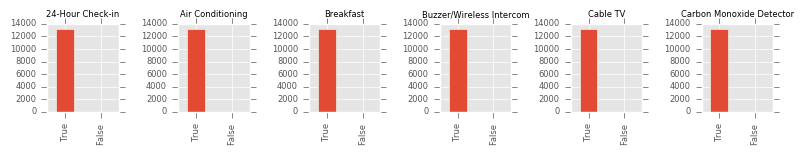

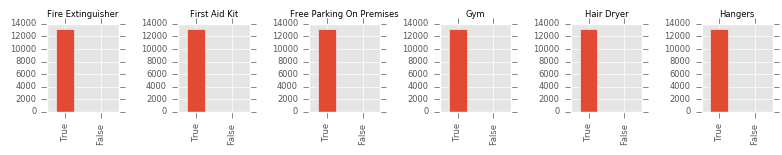

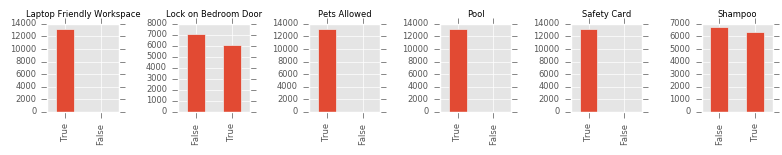

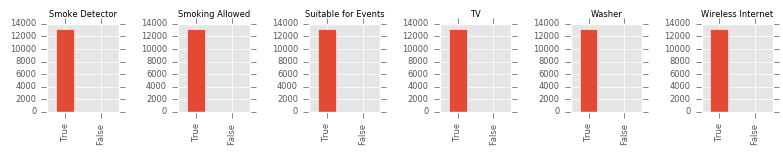

In [4]:
column_list = list(data.columns.values)
to_plot = [i for i in column_list if i != 'img_paths' and i != 'images'] # Discard image columns for exploration
last_amenity = to_plot.index("Wireless Internet") + 1 # Wireless Internet is last amenity column
amenities, columns = to_plot[:last_amenity], to_plot[last_amenity:]
plot_histograms(data, amenities, folder, 'amenities',
                fonts=6, grid=6, nrows=1, fig_size=(8, 1.5))

We can observe most of the amenities are present in almost all rooms studies. There are some open questions:

    - 'Locks on bedrooms' and 'Shampoo' are the only columns that show some disparity between their options. Why?
    - We do not expect so many rooms in Barcelona with Fireplace, Gym or Free Parking. Something wrong in the collection process?
    
Taking a lookg at the data we can observe how the number of services to True is the same in all cases. That also raises an alarm. Due to the uncertainity of the validity on the services we prefer to discard this information.

In [5]:
def drop_columns(d, c):
    """ Drops the given columns from the data"""
    for i in c:
        d.drop(i, inplace=True, axis=1)
        
drop_columns(data, amenities)

## Feature columns

Now let's take a look at the the rest of the columns present in the dataset. First, let's have an overview.

In [6]:
column_data = data[columns]
column_data.describe()

accommodates bathrooms bedrooms cancelation_policy cleaning_fee  \
count         13157     13157    13157              13157        13157   
unique           10        10       12                  5           63   
top               2      1.00     1.00             strict                
freq           5125      9444     8360               5308        12233   

       deleted host_id host_is_superhost host_listings_count  \
count    13157   13157             13157               13157   
unique       1    8104                 3                  37   
top          0  396363                 f                   1   
freq     13157      53             13002                6056   

                     last_modified   latitude longitude m_discount minstay  \
count                        13157      13157     13157      13157   13157   
unique                       13157      11480     11774         75      22   
top     2016-04-08 16:14:04.426393  41.380200  2.180613          0       1   
freq                             1          4         4       6679    4491   

       neighborhood neighborhood_overview overall_satisfaction  price  \
count         13157                 13157                13157  13157   
unique           28                  4377                    9    473   
top        Barcelon                                        4.5     35   
freq          13091                  7911                 4571    548   

       property_type reviews_count  room_id        room_type sec_deposit  \
count          13157         13157    13157            13157       13157   
unique            16            17    13157                3          54   
top        Apartment                2616269  Entire home/apt               
freq           11595         13139        1             6879       12444   

       survey_id transit w_discount  
count      13157   13157      13157  
unique         1    4236         52  
top            5                  0  
freq       13157    8188       7103

In [7]:
for i in columns:
    print('Values for "{}" are: {}'.format(i, column_data[i].unique()))

Values for "accommodates" are: [u'' u'3' u'4' u'2' u'5' u'1' u'6' u'10' u'13' u'16']
Values for "bathrooms" are: [u'3.00' u'1.00' u'2.00' u'' u'4.00' u'5.00' u'0.00' u'6.00' u'8.00'
 u'7.00']
Values for "bedrooms" are: [u'4.00' u'1.00' u'0.00' u'2.00' u'3.00' u'5.00' u'6.00' u'' u'7.00'
 u'10.00' u'8.00' u'9.00']
Values for "cancelation_policy" are: [u'flexible' u'strict' u'moderate' u'' u'super_strict_30']
Values for "cleaning_fee" are: [u'' u'23' u'47' u'35' u'18' u'59' u'53' u'70' u'12' u'29' u'6' u'65' u'24'
 u'76' u'22' u'41' u'94' u'88' u'8' u'58' u'11' u'82' u'176' u'117' u'45'
 u'109' u'106' u'80' u'7' u'100' u'294' u'81' u'46' u'113' u'26' u'43'
 u'96' u'49' u'71' u'9' u'324' u'61' u'14' u'147' u'141' u'129' u'50'
 u'118' u'5' u'15' u'200' u'55' u'123' u'56' u'19' u'188' u'20' u'153'
 u'38' u'112' u'135' u'40' u'39']
Values for "deleted" are: [u'0']
Values for "host_id" are: [u'7014330' u'24177368' u'51388490' ..., u'8538802' u'3986759' u'9445480']
Values for "host_is_superhos

Visualize the relevance of the missing values in front of the rest. Depending on the number of missings for each column we will decide what action to perform: eliminate, impute, etc.

In [8]:
total = float(data.shape[0])
columns = [i for i in data.columns.values] + ['img_paths', 'images'] # Explore images content here
for i in columns:
    empty_rows = data[data[i] == ''].shape[0]
    nan_rows = data[data[i].isnull()].shape[0]
    print('-> "{}": Ratio of empty instances: {}, ratio of NaN values: {}'.
          format(i, empty_rows/total, nan_rows/total))

-> "accommodates": Ratio of empty instances: 0.160066884548, ratio of NaN values: 0.0
-> "bathrooms": Ratio of empty instances: 0.0862658660789, ratio of NaN values: 0.0
-> "bedrooms": Ratio of empty instances: 0.00129208786197, ratio of NaN values: 0.0
-> "cancelation_policy": Ratio of empty instances: 0.00205213954549, ratio of NaN values: 0.0
-> "cleaning_fee": Ratio of empty instances: 0.929771224443, ratio of NaN values: 0.0
-> "deleted": Ratio of empty instances: 0.0, ratio of NaN values: 0.0
-> "host_id": Ratio of empty instances: 0.0, ratio of NaN values: 0.0
-> "host_is_superhost": Ratio of empty instances: 0.00205213954549, ratio of NaN values: 0.0
-> "host_listings_count": Ratio of empty instances: 0.38405411568, ratio of NaN values: 0.0
-> "images": Ratio of empty instances: 0.00205213954549, ratio of NaN values: 0.0
-> "img_paths": Ratio of empty instances: 0.0, ratio of NaN values: 0.0
-> "last_modified": Ratio of empty instances: 0.0, ratio of NaN values: 0.0
-> "latitud

All missing values are empty spaces. Let's replace the 'blank spaces' by NaN so Pandas can easily identify them.

In [9]:
for i in data.columns.values:
    data[i][data[i] == ''] = np.NaN

### Discarding rows and columns

- Columns 'deleted' and 'survey_id' are not variables, so we eliminate them. 
- Number of hosts is not known by the Airbnb user and is very unpopulated, so we decide to erase it.
- Last modification does not seem to be very informative either, we decide to remove it.
- Neighborhood column is not representative at all. We decide to eliminate the column to rebuild it using the house coordinates.
- Rows which have any empty information related to images are discarded as well
- Images will be an important part in our process. We will discard those instances which have incomplete or inconsistent image data.

In [10]:
to_drop = ['survey_id', 'deleted', 'host_listings_count', 'last_modified', 'reviews_count']
drop_columns(data, to_drop)

# Rebuild neighborhoods
neighs = read_city_data(bcn_map)
data['longitude'] = pandas.to_numeric(data['longitude'])
data['latitude'] = pandas.to_numeric(data['latitude'])
data['neighborhood'] = data.apply(lambda row: get_neighborhood(neighs, row['longitude'], 
                                                               row['latitude']), axis=1)
# Remove latitude and longitude since they are not longer used
drop_columns(data, ['longitude', 'latitude'])

# Remove rows with missing image information
data = data[data['img_paths'].notnull()]
data = data[data['images'].notnull()]

# Drop inconsistent image data
def get_inc_rooms():
    """ Returns rows which have not proper image data """
    room_data = data.transpose()
    rooms = data['room_id'].tolist()
    inconsistent = []
    for i in rooms:
        current_row = room_data[int(i)]
        current_paths = current_row['img_paths']
        current_meta = {} if current_row['images'] is np.nan else json.loads(current_row['images'])
        # Inconsistent if differ attributes differ in length or 
        # if no image data available
        same_length = len(current_paths) == len(current_meta.keys())
        data_avail = len(current_paths) > 0
        if not (same_length and data_avail):
            inconsistent.append(int(i))
    return inconsistent

inc_rooms = get_inc_rooms()
for i in inc_rooms:
    data = data[data['room_id'] != str(i)]

### Missing values substitution

    - Impute accomodates, bathrooms, bedrooms, cancelation policies, property type using default values.
    - Set cleaning fee and security fee missing values to 0 (no fee).
    - If we do not know if host is superhost, we assume he/she is not.
    - For week and month discounts, we assume that missing values are 0 (no discount).
    - If minimum stay missing, we assume there is not (at least one day)
    - Neighborhood overview and transit text columns are deleted and consequently, creating two new
        columns that indicate their length.
    - We create a category 'Unknown' for missing neighborhoods.
    - We assume that instances that do not have overall satisfaction is mostly due to not being evaluated yet.
        We transform this column into a categorical one using the following levels:
            · up to 2 starts (two not included): very bad
            · from 2 to 3 starts (3 not included): bad
            · 3 to 4 starts (4 not included): good
            · 4 to 5: very good
            · 5: excellent

First, let's map the 'neighborhood_overview', 'transit' and 'overall_satisfaction' to their new form. We also map the 'host_is_superhost' column into  True and False values

In [11]:
def count_words(string):
    if string is np.nan:
        return 0
    else:
        return len(string.encode('utf-8'))
    
def define_satisfaction(inp):
    """ Returns the categorical value for the input score """
    if inp is np.nan:
        return 'not rated'
    else:
        score = float(inp)
        if score < 2:
            return 'very bad'
        elif score >=2 and score < 3:
            return 'bad'
        elif score >= 3 and score < 4:
            return "good"
        elif score >= 4 and score < 5:
            return "very good"
        elif score == 5:
            return "excellent"
        else:
            raise ValueError('Unexpected score of ' + str(score))

def define_host_type(x):
    """ Maps host type into boolean values """
    if x == 'f' or x == '' or x is np.nan:
        return False
    elif x == 't':
        return True
    else:
        raise ValueError('Unknown host type {}'.format(x))
            
# Map columns
data['neighborhood_overview'] = data['neighborhood_overview'].apply(count_words)
data['transit'] = data['transit'].apply(count_words)
data['overall_satisfaction'] = data['overall_satisfaction'].apply(define_satisfaction)
data['host_is_superhost'] = data['host_is_superhost'].apply(define_host_type)

Now we assign the type of each column to its corresponding one.

In [12]:
def map_columns(data, cols, typ):
    """ Maps the given columns in the data to the corresponding type """
    for i in cols:
        data[i] = data[i].astype(typ)

numeric = ['accommodates', 'bathrooms', 'bedrooms', 'minstay', 'transit', 'neighborhood_overview']
numericf = ['cleaning_fee', 'sec_deposit', 'm_discount', 'w_discount', 'price']
categories = ['cancelation_policy', 'overall_satisfaction', 'property_type', 'room_type', 'neighborhood']
boolean = ['host_is_superhost']

map_columns(data, numeric + numericf, float)
map_columns(data, categories, "category")
map_columns(data, boolean, 'bool')

Before replacing the missing values, let's visualize the data.

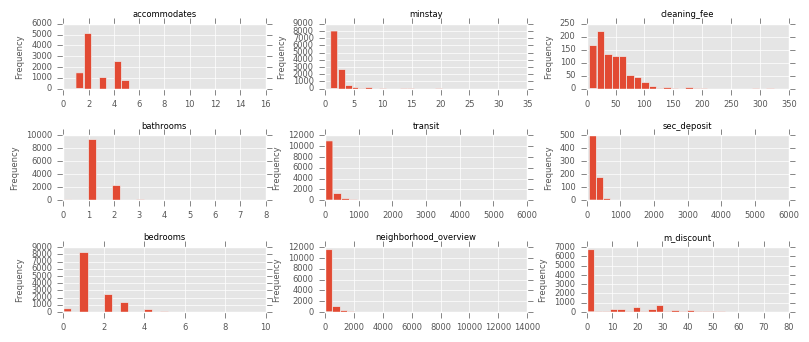

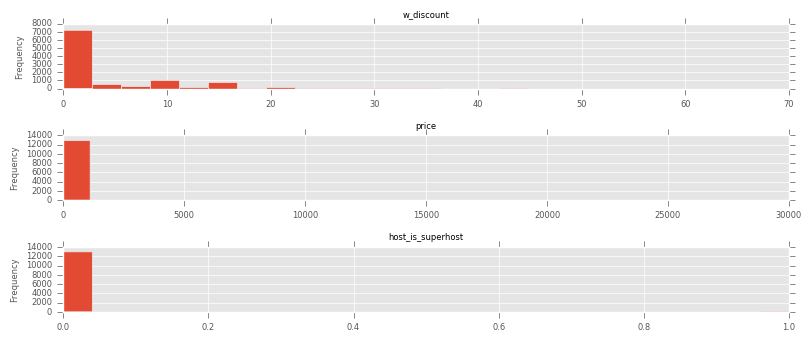

In [14]:
# Let's plot numeric columns
plot_histograms(data, var=numeric + numericf + boolean, 
                path=folder, 
                prefix='boolean_numeric_nan',
                nrows=3,
                grid=9,
                bins=25,
                fig_size=(8, 3.5),
                fonts=6)

We can observe how there is clearly a frequent value/interval in all the columns. Now we have a look at the categorical variables.

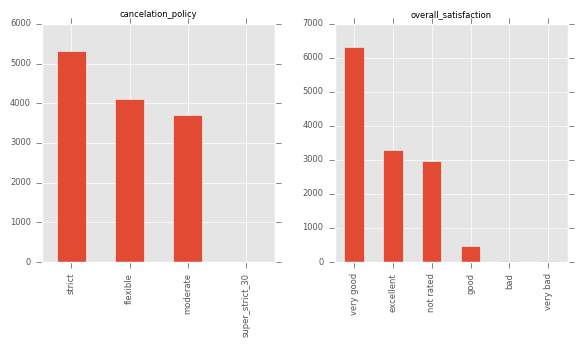

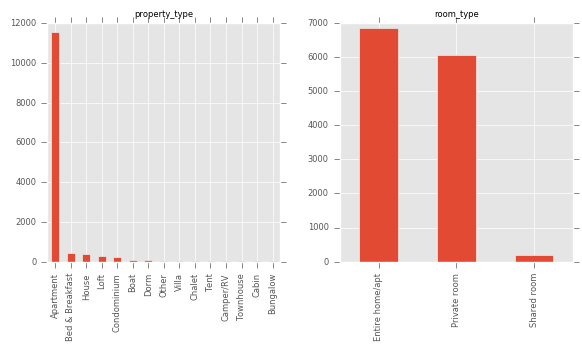

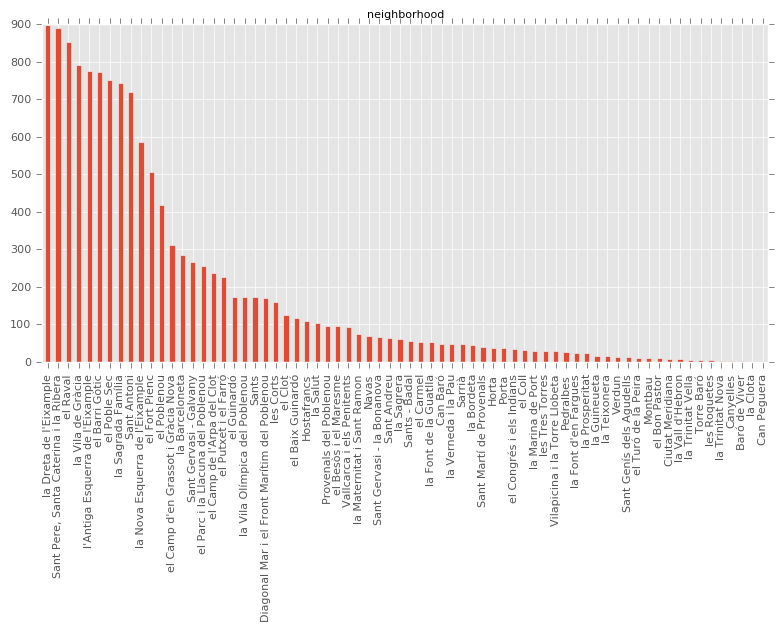

In [15]:
plot_histograms(data, var=['cancelation_policy', 'overall_satisfaction'], 
                path=folder, 
                prefix='categories_nan1',
                nrows=1,
                grid=4,
                bins=25,
                fig_size=(6, 3),
                fonts=6)

plot_histograms(data, var=['property_type', 'room_type'], 
                path=folder, 
                prefix='categories_nan2',
                nrows=1,
                grid=4,
                bins=25,
                fig_size=(6, 3),
                fonts=6)

plot_histograms(data, var=['neighborhood'], 
                path=folder, 
                prefix='categories_nan3',
                nrows=1,
                grid=4,
                bins=25,
                fig_size=(8, 4),
                fonts=8)

Categorical information show that most of the offers are apartments (entire apartment) using strict cancelation
policy and, whenever there is a rate, it is usually very good. Most apartments are lookated, as expected,
in the most turistic areas.

Now let's replace the missing values following the logics described previously.
Note that 'transit', 'overall_satisfaction' and 'neighborhood_overview' already dealt with that.

In [16]:
# Since 'strict' is the most common policy, we replace the missing (~0.2%) with this value
data['cancelation_policy'] = data['cancelation_policy'].fillna('strict')
# Same for 'property_type'. We assume 'Apartment' for the missing (~0.2%)
data['property_type'] = data['property_type'].fillna('Apartment')
# Most of the users are not superhosts
data['host_is_superhost'] = data['host_is_superhost'].fillna(False)
# Cleaning fee and deposit missings are 0
data['sec_deposit'] = data['sec_deposit'].fillna(0.0)
data['cleaning_fee'] = data['cleaning_fee'].fillna(0.0)
# Same for week and month discounts
data['m_discount'] = data['m_discount'].fillna(0.0)
data['w_discount'] = data['w_discount'].fillna(0.0)
# We assume one bathrooms is the general rule
data['bathrooms'] = data['bathrooms'].fillna(1.0)
# Minimum stay if missing is one single day (no minimum)
data['minstay'] = data['minstay'].fillna(1)
# Neighborhoods
data['neighborhood'] = data.neighborhood.cat.add_categories(["Unknown"])
data['neighborhood'] = data['neighborhood'].fillna("Unknown")

def fill_acommodates(accom, beds):
    """ Returns the corresponding value for the number of rooms
    given the vale of the column and the number of beds of the offer """
    if np.isnan(accom):
        if not np.isnan(beds):
            return beds
        else:
            return 1
    else:
        return accom
    

def fill_bedrooms(beds, accom):
    """ Returns the corresponding value for the number of rooms
    given the vale of the column and the number of beds of the offer """
    if np.isnan(beds):
        if not np.isnan(accom):
            return accom
        else:
            return 1
    else:
        return beds

data['accommodates'] = data.apply(lambda row: fill_acommodates(row['accommodates'], 
                                                               row['bedrooms']), axis=1)
data['bedrooms'] = data.apply(lambda row: fill_acommodates(row['bedrooms'], 
                                                               row['accommodates']), axis=1)

After replacing the missing values, we expect distributions to be very similar to the ones visualized in the beginning. In most of the cases we have enforced the most popular option. The following plots confirm this. Note that there is a new neighborhood category 'Unknown' lying around the median of the column nowss.

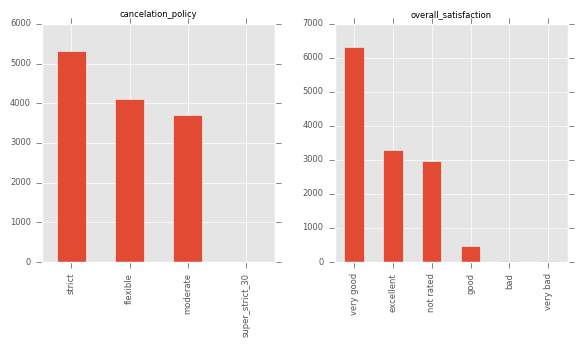

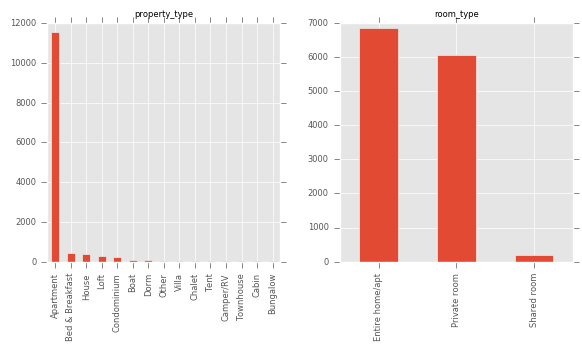

In [17]:
plot_histograms(data, var=numeric + numericf + boolean, 
                path=folder, 
                prefix='boolean_numeric',
                nrows=3,
                grid=12,
                bins=25,
                fig_size=(8, 4.5),
                fonts=6)

plot_histograms(data, var=['cancelation_policy', 'overall_satisfaction'], 
            path=folder, 
            prefix='categories1',
            nrows=1,
            grid=4,
            bins=25,
            fig_size=(6, 3),
            fonts=6)

plot_histograms(data, var=['property_type', 'room_type'], 
            path=folder, 
            prefix='categories2',
            nrows=1,
            grid=4,
            bins=25,
            fig_size=(6, 3),
            fonts=6)

plot_histograms(data, var=['neighborhood'], 
            path=folder, 
            prefix='categories3',
            nrows=1,
            grid=4,
            bins=25,
            fig_size=(8, 4),
            fonts=6)

Finally, let's check for missing values again and confirm there is nothing missing.

In [18]:
# Recheck missings
total = float(data.shape[0])
for i in data.columns.values:
    empty_rows = data[data[i].isnull()].shape[0]
    print('Nan values for "{}" are: {}'.format(i, empty_rows/total))

Nan values for "accommodates" are: 0.0
Nan values for "bathrooms" are: 0.0
Nan values for "bedrooms" are: 0.0
Nan values for "cancelation_policy" are: 0.0
Nan values for "cleaning_fee" are: 0.0
Nan values for "host_id" are: 0.0
Nan values for "host_is_superhost" are: 0.0
Nan values for "images" are: 0.0
Nan values for "img_paths" are: 0.0
Nan values for "m_discount" are: 0.0
Nan values for "minstay" are: 0.0
Nan values for "neighborhood" are: 0.0
Nan values for "neighborhood_overview" are: 0.0
Nan values for "overall_satisfaction" are: 0.0
Nan values for "price" are: 0.0
Nan values for "property_type" are: 0.0
Nan values for "room_id" are: 0.0
Nan values for "room_type" are: 0.0
Nan values for "sec_deposit" are: 0.0
Nan values for "transit" are: 0.0
Nan values for "w_discount" are: 0.0


Let's convert absolute image paths to relative image paths.

In [19]:
def to_relative(path):
    """ Returns the relative path of the image from the Airbnb image root folder """
    prefix = '/Users/Pere/Desktop/scraper/airbnb_imgs/'
    if path.startswith(prefix):
        return path[len(prefix):].strip()
    else:
        raise RuntimeError('Unexpected path format: %s' % path)

def replace_paths(path_list):
    """ Replaces the absolute paths to relative paths """
    return [to_relative(p) for p in path_list]

data['img_paths'] = data['img_paths'].apply(replace_paths)

### Adding two more columns

We are also interested in adding information related to the number of pictures for each room as well as the ratio of official pictures from Airbnb among all the pictures available

In [20]:
def read_image_metadata(column):
    """ Reads image metadata column into a dictionary """
    return json.loads(column)

def get_off_ratio(images):
    """ Returns the raito of official Airbnb pictures for the given image set """
    parsed = read_image_metadata(images)
    official = [value[1] for (key, value) in list(parsed.iteritems())]
    return sum(official)/float(len(official))
    
def get_num(images):
    """ Returns the number of pictures for the given set """
    parsed = read_image_metadata(images)
    return len(parsed.keys())

data['num_images'] = data['images'].apply(get_num)
data['official_ratio']= data['images'].apply(get_off_ratio)

Finally, let's update the price (target column) with the cleaning fee since it is charged at the end as 
part of the price of the stay.

In [21]:
data['price'] = data.apply(lambda row: row['cleaning_fee'] + row['price'], axis=1)

Store resulting dataset into a new location

In [22]:
data.to_json(dst_path)